## Predict Good Amazon Review：

### 0. Data import & parse:

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#h2o.cluster().shutdown()

In [3]:
min_mem_size=30 
run_time=500

In [4]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
# min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

30


In [5]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.144-b01, mixed mode)
  Starting server from c:\python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ZIWEIF~1\AppData\Local\Temp\tmpqfn3ipas
  JVM stdout: C:\Users\ZIWEIF~1\AppData\Local\Temp\tmpqfn3ipas\h2o_Zi_Wei_Fan_started_from_python.out
  JVM stderr: C:\Users\ZIWEIF~1\AppData\Local\Temp\tmpqfn3ipas\h2o_Zi_Wei_Fan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.5
H2O cluster version age:,27 days
H2O cluster name:,H2O_from_python_Zi_Wei_Fan_cz7vu0
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [6]:
data_path = "Dataset/AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
reviews.shape

(55554, 10)

In [8]:
reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"


Add Target Column: "PositiveReview", mean score around 4.2

In [9]:
reviews['PositiveReview']=(reviews['Score']>=4.2).ifelse('1','0')

In [10]:
reviews.head(2)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0


In [11]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,20106
1,35448


### 1. Train Baseline Model:
We will start by training a baseline model that does not use the review and instead uses other attributes in our dataset.

In [12]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob=[0.8])
time_split

Probs,TimeQuantiles
0.8,1.33644e+09


In [13]:
time_split=time_split[1]

In [14]:
reviews['Train']=(reviews['Time']<time_split).ifelse("Yes","No")
reviews['Train'].head(3)

Train
No
Yes
Yes


The 'Time' is the line to split the train set & test set.

In [15]:
train = reviews[reviews['Train'] == 'Yes']
test = reviews[reviews['Train'] == 'No']

- Train an baseline model: GradientBoostingEstimator.

In [16]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm_baseline.hex')
gbm_baseline.train(x = predictors, 
                   y = response,
                  training_frame = train,
                  validation_frame = test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


- Calculate AUC & Confusion Matrix:

In [17]:
print("AUC on validation data: " + str(round(gbm_baseline.auc(valid = True), 3)))

AUC on validation data: 0.595


In [18]:
gbm_baseline.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48181784133938027: 


,0,1,Error,Rate
0,640.0,3572.0,0.8481,(3572.0/4212.0)
1,237.0,6703.0,0.0341,(237.0/6940.0)
Total,877.0,10275.0,0.3416,(3809.0/11152.0)


In [19]:
gbm_baseline.r2(train=True, valid=True)

{'train': 0.167988645532125, 'valid': 0.04741187777451328}

### 2. Interpret based on Baseline Model (GradientBoosting)

- Plot Variable Importance: 

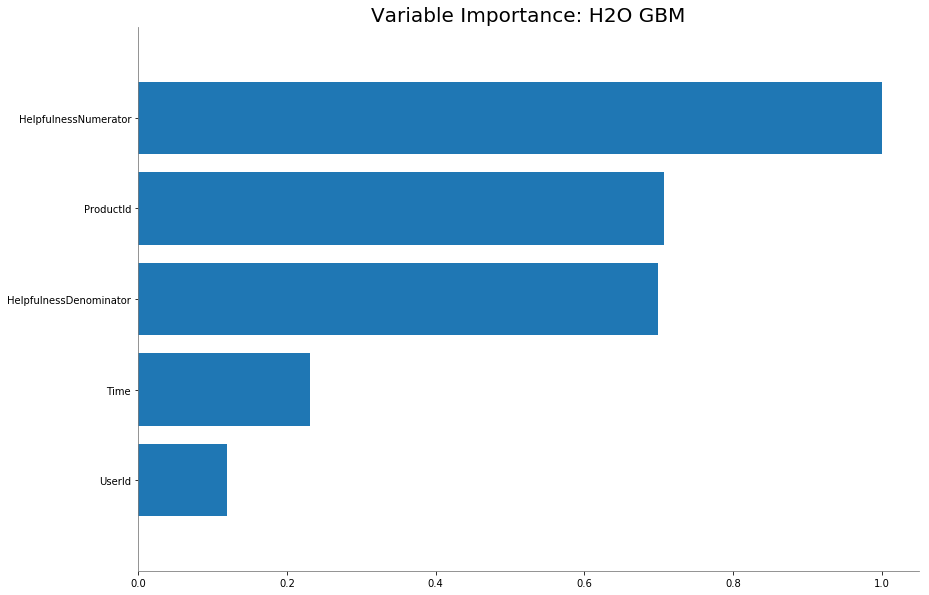

In [20]:
gbm_baseline.varimp_plot()

- Partial Dependence Plot:  
Based on the top1 feature-'HelpfulnessNumerator':

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


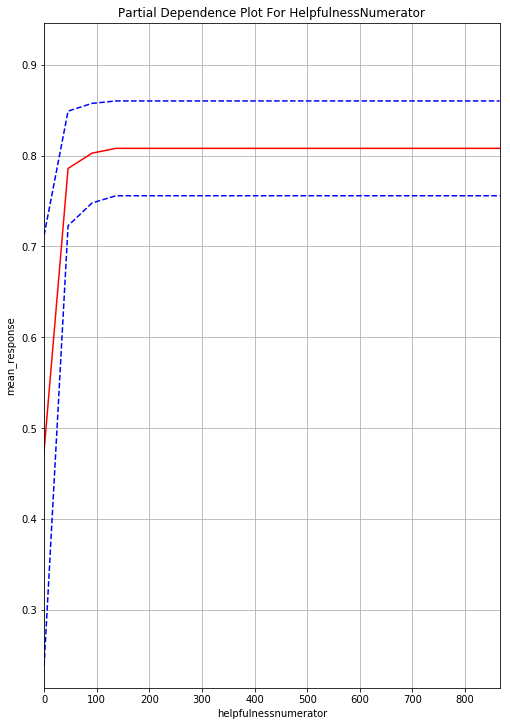

In [21]:
%matplotlib inline
pdp_helpfulness = gbm_baseline.partial_plot(train, cols = ['HelpfulnessNumerator'])

### 3. Tokenize words in Review:

- The tokenize():  
    This will __split the reviews into words and remove any stop words, small words, or words with numbers in them__.

In [22]:
data_path = "Dataset/stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [23]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize('\\W+')
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2)|(tokenized_lower.isna()), :]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True), :]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)), :]
    return tokenized_words

In [24]:
words = tokenize(reviews['Text'])

In [25]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


### 4. Train Word2Vec Model:

#### The purpose and usefulness of Word2vec is to group the vectors of similar words together in vectorspace.  
Word2vec can make highly accurate guesses about a word’s meaning based on past appearances.  

In [26]:
from h2o.estimators.word2vec import H2OWord2vecEstimator

- Train Word2Vec model:

In [27]:
'''
w2v_model = H2OWord2vecEstimator(vec_size=100, model_id="w2v.hex")
w2v_model.train(training_frame = words)

models_path = 'data'
h2o.save_model(w2v_model, path=models_path, force=True)
'''

- Pre-trained model built with commented out code

In [28]:
w2v_model = h2o.load_model('data/w2v.hex')

- Find synonyms for the word 'coffee'

In [29]:
w2v_model.find_synonyms("coffee", count=5)

OrderedDict([('coffe', 0.7971817851066589),
             ('coffees', 0.7716221213340759),
             ('espresso', 0.7542204260826111),
             ('expresso', 0.7467491030693054),
             ('brew', 0.7268418669700623)])

In [30]:
w2v_model.find_synonyms("stale", count=7)

OrderedDict([('rancid', 0.6558939814567566),
             ('tasteless', 0.616191029548645),
             ('staleness', 0.6071882843971252),
             ('moldy', 0.6061089634895325),
             ('inedible', 0.5991473197937012),
             ('unedible', 0.5878211855888367),
             ('smashed', 0.5808124542236328)])

- Calculate a vector for each review

In [31]:
review_vecs = w2v_model.transform(words, aggregate_method="AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.194685,0.00855027,0.0556024,0.0132407,-0.0412942,-0.0494328,0.110016,0.0748653,-0.0736722,0.264164,-0.00197007,-0.110286,-0.0680656,-0.0310144,-0.0648039,0.0899888,0.0196221,0.0874387,0.0919997,-0.0575128,0.0433614,0.0927071,0.0343757,-0.168186,0.036349,0.101088,0.151522,-0.0733731,0.0587866,0.0373975,0.00521516,0.0495378,0.121387,-0.128774,0.119871,-0.167793,-0.142495,0.0160686,-0.0942158,0.0782214,0.0924726,-0.0934786,0.00437295,-0.189194,0.15728,-0.15877,0.0298581,-0.0519759,-0.107477,-0.0115648,0.0818877,0.133477,-0.00474498,-0.0575912,-0.131289,0.048236,-0.101879,0.128776,0.0607913,0.175643,0.00525741,0.0868119,0.0192801,0.0542188,0.0523813,0.00845419,0.0297346,-0.144675,-0.0112719,-0.115776,-0.0484223,-0.142405,0.00573513,-0.184002,-0.0616234,0.185523,-0.0620329,0.110071,-0.150878,-0.184547,0.0779494,0.257534,0.131887,0.121781,0.0823335,0.184185,0.0292501,0.10686,-0.00565672,0.124804,0.011544,0.0871907,0.120759,-0.250487,0.00560116,0.0119901,0.00419926,0.0298412,0.212632,0.0151299
-0.0495431,0.23459,-0.0827007,0.0154918,0.118114,-0.0144093,-0.0488147,-0.0588248,-0.0695763,0.282987,0.268284,-0.0815992,-0.125285,-0.0521367,-0.133489,-0.0700413,0.125722,0.0471023,0.063242,0.0168585,0.0576769,0.0708625,-0.071372,-0.0973553,0.000624424,0.00212797,0.130798,0.0941267,-0.0560495,-0.0385939,-0.0913095,0.00962856,0.191518,-0.107817,0.0183072,-0.0593517,-0.0910883,-0.092331,0.00750446,0.0991813,0.0411738,0.0780529,-0.00188153,-0.0343744,0.250716,-0.116362,0.000327063,-0.0399014,-0.0452933,-0.0251108,0.104617,0.099187,0.05714,-0.0210452,-0.136585,0.138266,-0.0181873,0.017753,0.0733662,0.00892384,-0.069907,-0.0871948,0.0033325,-0.0299208,0.121225,0.0393036,-0.106652,-0.130082,0.0281483,-0.0679737,0.095394,-0.00755478,-0.0526662,-0.349726,0.0678052,0.0661074,-0.0266488,-0.01971,-0.008501,-0.185633,-0.173815,0.161362,-0.129495,0.182093,0.106462,0.184965,-0.0963331,0.0469011,-0.128881,0.124043,-0.0190084,0.177266,-0.14618,-0.0408715,0.0125225,-0.0588468,-0.0505257,0.0484574,0.0274838,0.296462
0.123161,0.0936158,0.0439947,-0.0151712,-0.0898124,-0.00271775,-0.000586845,-0.0464319,-0.0616804,0.356449,0.0611896,-0.0555226,-0.0893314,-0.06511,0.0159529,0.0564306,0.0834537,-0.0291296,0.0540183,-0.0330193,0.000493353,0.00640499,0.0458041,-0.135951,0.100869,0.143727,0.130937,-0.0333404,-0.0878446,0.0626354,-0.141847,0.186715,0.0569292,-0.115842,0.0843101,-0.12079,-0.0660873,-0.0679552,-0.00359153,0.171001,0.00265798,-0.110497,-0.0479786,-0.0355724,0.157841,-0.171527,0.15094,-0.0321921,-0.146142,0.104146,0.052199,0.100534,-0.0409051,0.0987403,-0.0842118,0.0706748,-0.092243,-0.017255,0.131373,0.0916262,-0.0156764,-0.00956439,0.0338077,-0.123931,-0.059287,0.0283973,-0.0351617,-0.26884,-0.0180109,-0.059145,-0.0604795,-0.0779308,0.064337,-0.271864,0.0140648,0.00949462,-0.027445,0.0794647,-0.12674,-0.145704,-0.00934821,0.150346,0.0965777,0.252518,0.068929,0.0254678,0.0683798,0.040232,-0.0694339,-0.0733179,-0.00590498,0.0111069,0.0116357,-0.115146,0.0506123,0.0630426,0.0671574,-0.0931774,0.16515,0.138782
0.14612,0.0524715,0.0431809,0.0417458,0.0543288,-0.010907,0.00472547,-0.0244389,-0.0179625,0.193643,-0.0203781,-0.00897748,-0.183371,-0.0736023,-0.0128042,0.00441256,0.173886,0.00884632,0.113344,0.108385,0.0807092,-0.00601381,0.0765061,-0.0862067,-0.0466725,0.12891,0.1632,-0.0324472,-0.203496,-0.0997903,-0.119647,-0.00812821,-0.00382883,-0.121207,0.0461597,-0.0302965,-0.0720886,-0.0146925,-0.113725,0.146578,0.0528954,-0.150499,-0.0290532,0.00109274,0.207615,-0.141456,0.104473,-0.0312056,-0.12619,0.171685,0.16485,0.0196136,-0.0562701,0.15984,-0.030217,0.120236,-0.04

In [32]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [33]:
ext_reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,0.194685,0.00855027,0.0556024,0.0132407,-0.0412942,-0.0494328,0.110016,0.0748653,-0.0736722,0.264164,-0.00197007,-0.110286,-0.0680656,-0.0310144,-0.0648039,0.0899888,0.0196221,0.0874387,0.0919997,-0.0575128,0.0433614,0.0927071,0.0343757,-0.168186,0.036349,0.101088,0.151522,-0.0733731,0.0587866,0.0373975,0.00521516,0.0495378,0.121387,-0.128774,0.119871,-0.167793,-0.142495,0.0160686,-0.0942158,0.0782214,0.0924726,-0.0934786,0.00437295,-0.189194,0.15728,-0.15877,0.0298581,-0.0519759,-0.107477,-0.0115648,0.0818877,0.133477,-0.00474498,-0.0575912,-0.131289,0.048236,-0.101879,0.128776,0.0607913,0.175643,0.00525741,0.0868119,0.0192801,0.0542188,0.0523813,0.00845419,0.0297346,-0.144675,-0.0112719,-0.115776,-0.0484223,-0.142405,0.00573513,-0.184002,-0.0616234,0.185523,-0.0620329,0.110071,-0.150878,-0.184547,0.0779494,0.257534,0.131887,0.121781,0.0823335,0.184185,0.0292501,0.10686,-0.00565672,0.124804,0.011544,0.0871907,0.120759,-0.250487,0.00560116,0.0119901,0.00419926,0.0298412,0.212632,0.0151299
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,-0.0495431,0.23459,-0.0827007,0.0154918,0.118114,-0.0144093,-0.0488147,-0.0588248,-0.0695763,0.282987,0.268284,-0.0815992,-0.125285,-0.0521367,-0.133489,-0.0700413,0.125722,0.0471023,0.063242,0.0168585,0.0576769,0.0708625,-0.071372,-0.0973553,0.000624424,0.00212797,0.130798,0.0941267,-0.0560495,-0.0385939,-0.0913095,0.00962856,0.191518,-0.107817,0.0183072,-0.0593517,-0.0910883,-0.092331,0.00750446,0.0991813,0.0411738,0.0780529,-0.00188153,-0.0343744,0.250716,-0.116362,0.000327063,-0.0399014,-0.0452933,-0.0251108,0.104617,0.099187,0.05714,-0.0210452,-0.136585,0.138266,-0.0181873,0.017753,0.0733662,0.00892384,-0.069907,-0.0871948,0.0033325,-0.0299208,0.121225,0.0393036,-0.106652,-0.130082,0.0281483,-0.0679737,0.095394,-0.00755478,-0.0526662,-0.349726,0.0678052,0.0661074,-0.0266488,-0.01971,-0.008501,-0.185633,-0.173815,0.161362,-0.129495,0.182093,0.106462,0.184965,-0.0963331,0.0469011,-0.128881,0.124043,-0.0190084,0.177266,-0.14618,-0.0408715,0.0125225,-0.0588468,-0.0505257,0.0484574,0.0274838,0.296462
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,Yes,0.123161,0.0936158,0.0439947,-0.0151712,-0.0898124,-0.00271775,-0.000586845,-0.0464319,-0.0616804,0.356449,0.0611896,-0.0555226,-0.0893314,-0.06511,0.0159529,0.0564306,0.0834537,-0.0291296,0.0540183,-0.0330193,0.000493353,0.00640499,0.0458041,-0.135951,0.100869,0.143727,0.130937,-0.0333404,-0.0878446,0.0626354,-0.141847,0.186715,0.0569292,-0.115842,0.0843101,-0.12079,-0.0660873,-0.0679552,-0.00359153,0.

### 5. Train GBM Model to Predict Good Review

- Train a GBM model with the same parameters as our baseline gbm. This time, however, we will add the aggregated word embeddings as predictors.

In [34]:
ext_train = ext_reviews[ext_reviews['Train']=='Yes']
ext_test = ext_reviews[ext_reviews['Train']=='No']

In [35]:
predictors

['ProductId',
 'UserId',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Time']

In [36]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'
predictors

['ProductId',
 'UserId',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Time']

In [37]:
gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex")
gbm_embeddings.train(x = predictors,
                    y = response,
                    training_frame = ext_train,
                    validation_frame = ext_test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [38]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))

Baseline AUC: 0.595
With Embeddings AUC: 0.595


In [39]:
gbm_embeddings.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48181784133938027: 


,0,1,Error,Rate
0,640.0,3572.0,0.8481,(3572.0/4212.0)
1,237.0,6703.0,0.0341,(237.0/6940.0)
Total,877.0,10275.0,0.3416,(3809.0/11152.0)


In [40]:
gbm_embeddings.r2(train=True, valid=True)

{'train': 0.167988645532125, 'valid': 0.04741187777451328}

### 6. Add summary column-GradientBoosting:
- Review column is not the only column with text, another column 'summary' which summarizes the review.  
- Add 'Summary' to check if this improves the model.

In [41]:
# Break summaries into sequence of word.
summary_words = tokenize(reviews['Summary'].ascharacter())

- Add aggregated summary word embeddings:

In [42]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method='AVERAGE')
summary_vecs.names = ['summary_'+ s for s in summary_vecs.names]

ext_reviews = ext_reviews.cbind(summary_vecs)

In [43]:
ext_train = ext_reviews[ext_reviews['Train']=='Yes']
ext_test = ext_reviews[ext_reviews['Train']=='No']

In [44]:
ext_train.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,summary_C1,summary_C2,summary_C3,summary_C4,summary_C5,summary_C6,summary_C7,summary_C8,summary_C9,summary_C10,summary_C11,summary_C12,summary_C13,summary_C14,summary_C15,summary_C16,summary_C17,summary_C18,summary_C19,summary_C20,summary_C21,summary_C22,summary_C23,summary_C24,summary_C25,summary_C26,summary_C27,summary_C28,summary_C29,summary_C30,summary_C31,summary_C32,summary_C33,summary_C34,summary_C35,summary_C36,summary_C37,summary_C38,summary_C39,summary_C40,summary_C41,summary_C42,summary_C43,summary_C44,summary_C45,summary_C46,summary_C47,summary_C48,summary_C49,summary_C50,summary_C51,summary_C52,summary_C53,summary_C54,summary_C55,summary_C56,summary_C57,summary_C58,summary_C59,summary_C60,summary_C61,summary_C62,summary_C63,summary_C64,summary_C65,summary_C66,summary_C67,summary_C68,summary_C69,summary_C70,summary_C71,summary_C72,summary_C73,summary_C74,summary_C75,summary_C76,summary_C77,summary_C78,summary_C79,summary_C80,summary_C81,summary_C82,summary_C83,summary_C84,summary_C85,summary_C86,summary_C87,summary_C88
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,-0.0495431,0.23459,-0.0827007,0.0154918,0.118114,-0.0144093,-0.0488147,-0.0588248,-0.0695763,0.282987,0.268284,-0.0815992,-0.125285,-0.0521367,-0.133489,-0.0700413,0.125722,0.0471023,0.063242,0.0168585,0.0576769,0.0708625,-0.071372,-0.0973553,0.000624424,0.00212797,0.130798,0.0941267,-0.0560495,-0.0385939,-0.0913095,0.00962856,0.191518,-0.107817,0.0183072,-0.0593517,-0.0910883,-0.092331,0.00750446,0.0991813,0.0411738,0.0780529,-0.00188153,-0.0343744,0.250716,-0.116362,0.000327063,-0.0399014,-0.0452933,-0.0251108,0.104617,0.099187,0.05714,-0.0210452,-0.136585,0.138266,-0.0181873,0.017753,0.0733662,0.00892384,-0.069907,-0.0871948,0.0033325,-0.0299208,0.121225,0.0393036,-0.106652,-0.130082,0.0281483,-0.0679737,0.095394,-0.00755478,-0.0526662,-0.349726,0.0678052,0.0661074,-0.0266488,-0.01971,-0.008501,-0.185633,-0.173815,0.161362,-0.129495,0.182093,0.106462,0.184965,-0.0963331,0.0469011,-0.128881,0.124043,-0.0190084,0.177266,-0.14618,-0.0408715,0.0125225,-0.0588468,-0.0505257,0.0484574,0.0274838,0.296462,-0.192725,0.31063,-0.0838579,-0.0416888,0.212666,-0.161145,0.0205124,0.0612359,-0.0975371,0.22784,0.365938,-0.070133,-0.181795,-0.0934692,-0.124666,-0.169826,0.0634467,-0.0430966,-0.0318442,-0.0279678,0.0529948,-0.0754962,-0.209299,-0.131492,0.0513214,0.0768279,0.0427143,0.175625,-0.0575678,0.0160989,-0.317888,-0.0697213,0.149864,-0.12392,0.0198951,-0.0547031,-0.0451698,-0.215154,-0.0125563,0.0782037,-0.00192,0.162176,-0.115732,0.00452397,0.409675,-0.0841313,-0.158863,-0.0330333,-0.0218781,0.0143843,0.0761459,0.0615826,0.0730586,0.149658,-0.21679,0.128949,-0.0563934,0.0240134,-0.00904656,0.0568181,-0.107004,-0.102585,0.0588165,0.28908,0.132174,-0.0224344,-0.184066,-0.0300823,0.0707774,-0.216979,0.0636379,0.122245,0.0427629,-0.402555,0.0804202,0.108368,-0.00634667,-0.0606998,0.0791236,-0.193004,-0.40509,0.133935,-0.108571,0.320315,0.200286,0.122987,-0.189933,0.0390492
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipu

In [45]:
predictors = predictors + summary_vecs.names
response = 'PositiveReview'

gbm_plus_summary = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_plus_summary.hex")
gbm_plus_summary.train(x=predictors, 
                       y=response, 
                       training_frame = ext_train,
                      validation_frame = ext_test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


- Check AUC:

In [46]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))
print("With Summary and Review Embeddings AUC: " + str(round(gbm_plus_summary.auc(valid = True), 3)))

Baseline AUC: 0.595
With Embeddings AUC: 0.595
With Summary and Review Embeddings AUC: 0.804


In [47]:
gbm_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4654341873712428: 


,0,1,Error,Rate
0,1892.0,2320.0,0.5508,(2320.0/4212.0)
1,500.0,6440.0,0.072,(500.0/6940.0)
Total,2392.0,8760.0,0.2529,(2820.0/11152.0)


In [48]:
gbm_plus_summary.r2(train=True, valid=True)

{'train': 0.35840185934403446, 'valid': 0.2759494781963455}

### 7. Check Interpretable plot:

#### 7.1 Variable/Feature Importance:

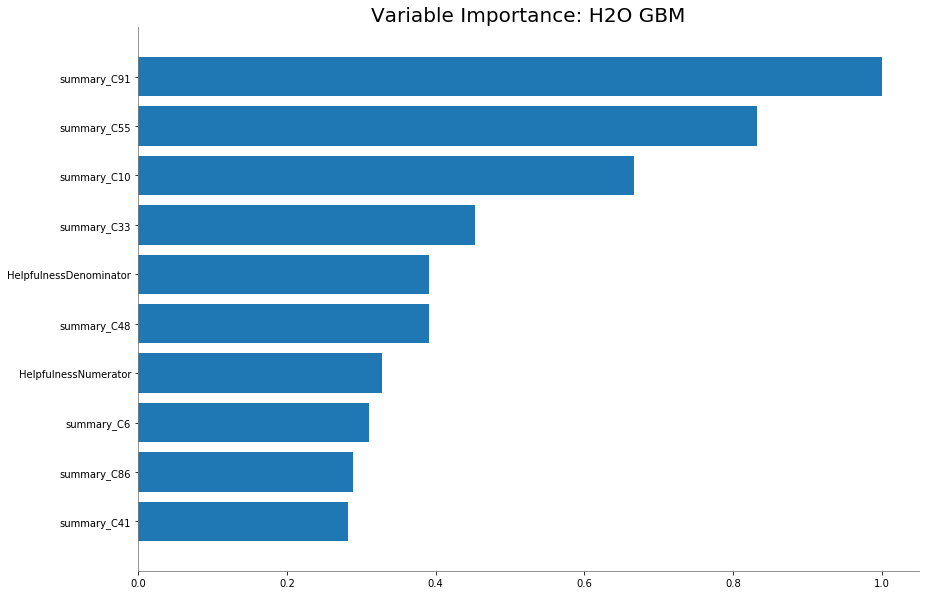

In [49]:
gbm_plus_summary.varimp_plot()

#### 7.2 PartialDependency Plot:

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


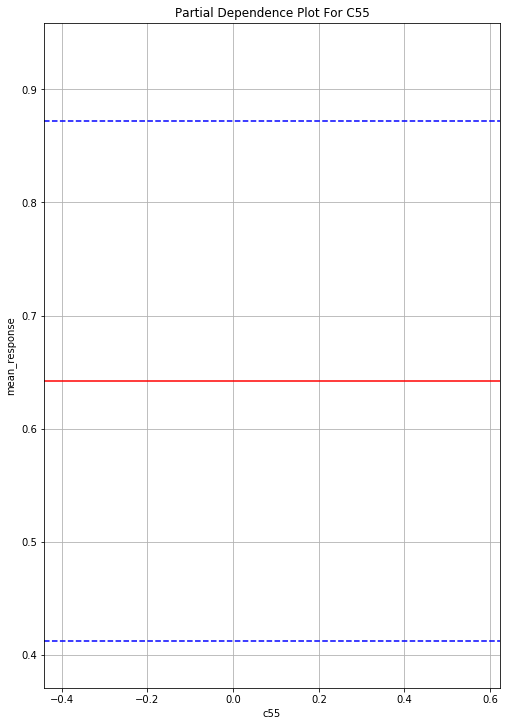

In [50]:
pdp_word_vecs = gbm_plus_summary.partial_plot(data=ext_train, cols=['C55'])

### 8. Predict a new review:

- Define predict function:

In [51]:
def predict(reviews, w2v, gbm):
    words = tokenize(reviews['Text'].ascharacter())
    reviews_vec = w2v.transform(words, aggregate_method = 'AVERAGE')
    
    summary_words = tokenize(reviews['Summary'].ascharacter())
    summary_vec = w2v.transform(summary_words, aggregate_method='AVERAGE')
    
    model_data = reviews.cbind(reviews_vec).cbind(summary_vec)
    print(gbm.predict(model_data))

- Prepare some reviews:

In [52]:
# Good:
good_review = h2o.H2OFrame([["B000EQT574", "AISQLBDGS2KXR", 1, 1, 1263340800, 
                             "Delicious",
                             "These chips are delicious. Salty sweet with a hint of spice. I have no idea how Tamari is supposed to taste, but these chips are awesome. I just finished an entire bag in one day!"]])

good_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [53]:
# Bad:
bad_review = h2o.H2OFrame([["B003BJZMSM", "A2JBZHQVQF7MV0", 1, 2, 1274832000, 
                            "Pretty tasteless",
                            "Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."]])
bad_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


- Predict:

In [54]:
print('Good review:  ')
print(predict(good_review, w2v_model, gbm_embeddings))

print('Bad review:  ')
print(predict(bad_review, w2v_model, gbm_embeddings))

Good review:  
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.240346,0.759654



None
Bad review:  
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.437581,0.562419



None


- Because most currently-available explanatory techniques are approximate, it is recommended that users employ several different explanatory techniques and trust only consisent results across techniques:

### 9. Train Logistic Regression Model to Predict Good Review--Ziwei:
Train a Logistic Regression model. This time, however, we will add the aggregated word embeddings as predictors.

#### 9.1 Train LR Without Adding summary:

In [55]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

In [56]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_logistic = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic.train(x = predictors, 
                   y= response, 
                   training_frame = ext_train, 
                   validation_frame = ext_test, 
                   model_id = "glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


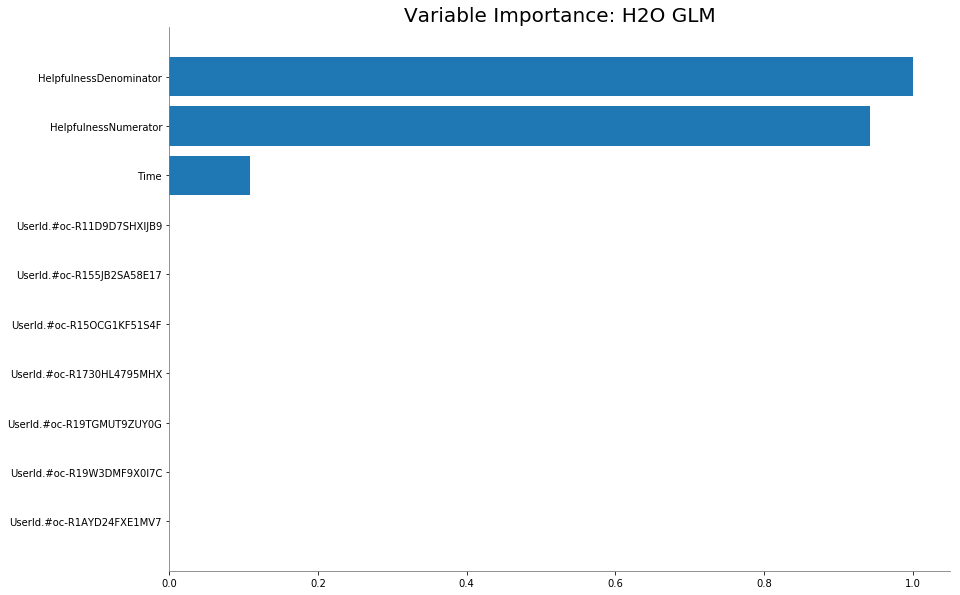

In [57]:
glm_logistic.varimp_plot()

In [58]:
print("With Embeddings AUC: " + str(round(glm_logistic.auc(valid = True), 3)))

With Embeddings AUC: 0.571


In [59]:
glm_logistic.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5942608314291075: 


,0,1,Error,Rate
0,792.0,3420.0,0.812,(3420.0/4212.0)
1,320.0,6620.0,0.0461,(320.0/6940.0)
Total,1112.0,10040.0,0.3354,(3740.0/11152.0)


In [60]:
glm_logistic.r2(train=True, valid=True)

{'train': 0.04539674737969146, 'valid': 0.012434577918252532}

#### 9.2 Train LR Adding Summary:

In [61]:
predictors = predictors + summary_vecs.names
response = 'PositiveReview'

In [62]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train, 
                               validation_frame = ext_test, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [63]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.791


In [64]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44924360656168666: 


,0,1,Error,Rate
0,1606.0,2606.0,0.6187,(2606.0/4212.0)
1,405.0,6535.0,0.0584,(405.0/6940.0)
Total,2011.0,9141.0,0.27,(3011.0/11152.0)


In [65]:
glm_logistic_plus_summary.r2(train=True, valid=True)

{'train': 0.24113803760741437, 'valid': 0.24372179952297546}

#### 9.3 Check the Variable importance

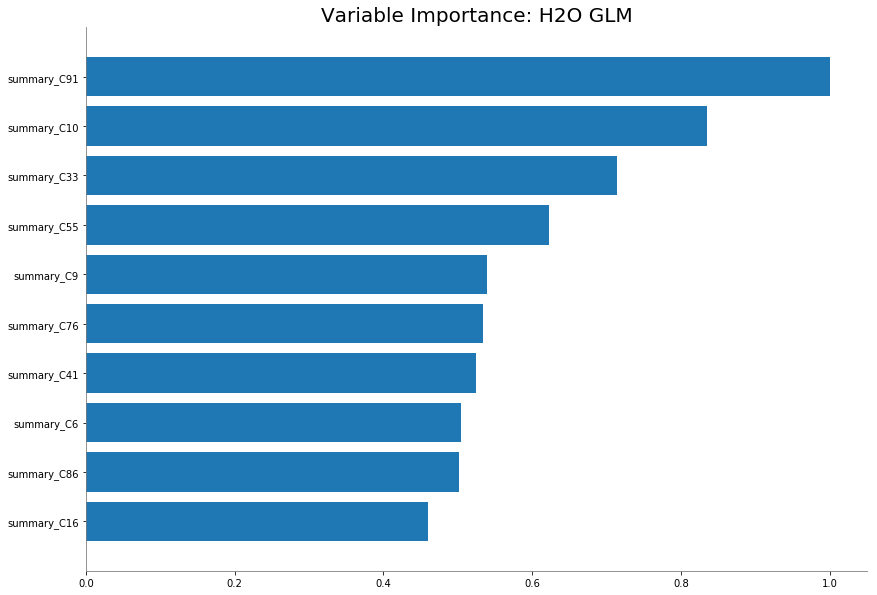

In [66]:
glm_logistic_plus_summary.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


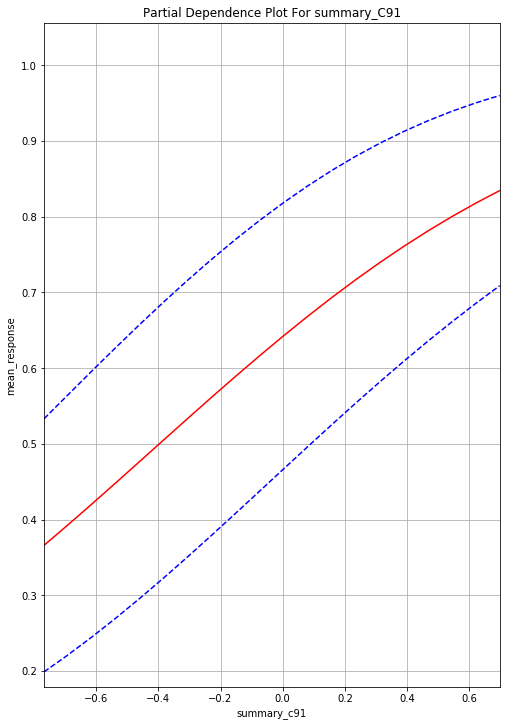

In [67]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train, cols = ["summary_C91"])

### 10. Train Surrogate model Linear Regression

- Linear regression corresponds to the Gaussian family model: the link function g
is the identity and the density f corresponds to a normal distribution.
- It is faster and requires more stable computations.

#### 10.1 Train Linear Regression surrogate model-Without Summary:

In [117]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [118]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

In [119]:
# initialize
local_glm = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)

In [120]:
# train 
local_glm.train(x=predictors, y=response, training_frame=ext_train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [121]:
# coefs
import operator

print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm.r2())


Local GLM Coefficients:
HelpfulnessDenominator:   -0.41926934342835226
ProductId.B004ZIER34:     -0.37339277539619153
ProductId.B001LGGH40:     -0.2698782308362946
ProductId.B0041NYV8E:     -0.2532379368298235
ProductId.B001LG945O:     -0.12868058701620463
ProductId.B0090X8IPM:     -0.09412472662395467
ProductId.B000KV7ZGQ:     -0.07866755079650026
ProductId.B004U49QU2:     -0.07021864576873936
ProductId.B004YV80OE:     -0.06915293570209137
ProductId.B005A1LJ04:     -0.03411732700989435
ProductId.B001LG940E:     -0.0069696884081249235
Time:                     -3.8978762164590725e-09
ProductId.B001EO5Q64:     0.07420423419653041
ProductId.B000NMJWZO:     0.10707096101008066
HelpfulnessNumerator:     0.44168744660951176
Intercept:                5.762345944335135

Local GLM R-square:
0.09


In [131]:
local_glm.r2(train=True, valid=True)

{'train': 0.09367721803026086, 'valid': None}

In [123]:
local_glm.auc()

0.6624231687765739

In [124]:
local_glm.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5395303392433897: 


,0,1,Error,Rate
0,3099.0,12795.0,0.805,(12795.0/15894.0)
1,822.0,27686.0,0.0288,(822.0/28508.0)
Total,3921.0,40481.0,0.3067,(13617.0/44402.0)


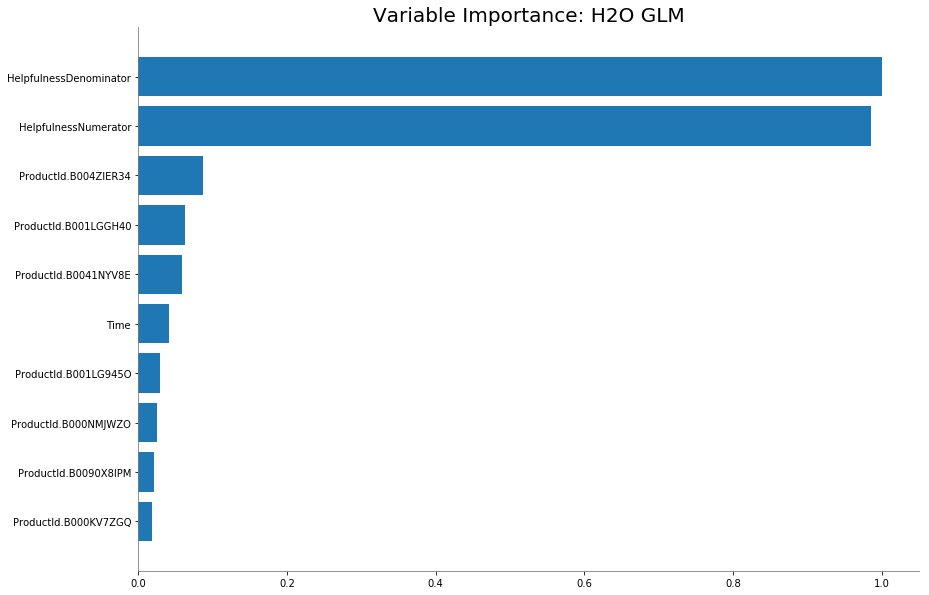

In [133]:
local_glm.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


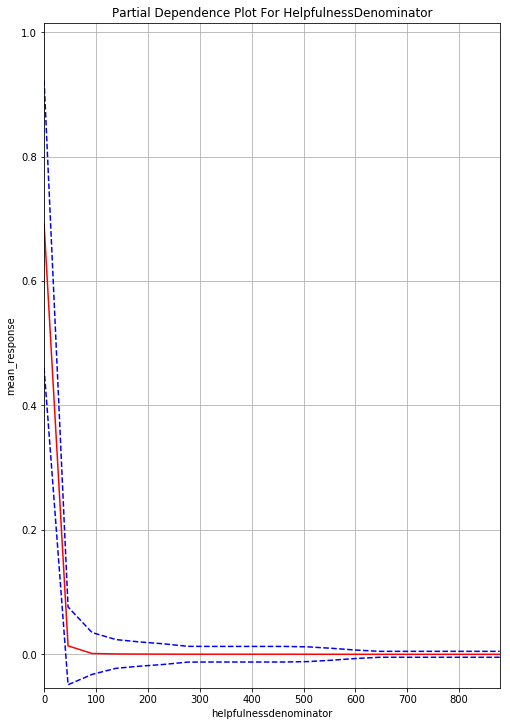

In [134]:
pdp_local_linear = local_glm.partial_plot(data = ext_train, cols = ["HelpfulnessDenominator"])

#### 10.2 Train Linear Regression surrogate model-Add Summary:

In [125]:
predictors = predictors + summary_vecs.names
response = 'PositiveReview'

In [126]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)
# train 
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [127]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
summary_C10:              -1.4021085841238106
summary_C33:              -1.1831510709669475
summary_C7:               -1.144753407801006
summary_C76:              -1.1290022315894315
summary_C41:              -1.0934502932294765
summary_C6:               -1.0740527447181683
summary_C86:              -1.064976400452503
summary_C16:              -0.9289289711931945
summary_C2:               -0.8637584183720214
summary_C31:              -0.8266357558759467
summary_C38:              -0.8006405948997042
summary_C92:              -0.7589737030372359
summary_C11:              -0.676821915392257
summary_C30:              -0.6093486217810294
summary_C28:              -0.5989113180491281
summary_C96:              -0.5328078406335021
summary_C51:              -0.5252408977843847
summary_C53:              -0.4905926657976115
summary_C67:              -0.4902937952272365
summary_C40:              -0.48915583814093216
summary_C93:              -0.4712865045933581
summary_C68

In [132]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.2922591540483098, 'valid': None}

In [129]:
local_glm_plus.auc()

0.8121313865983439

In [130]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4661578068431589: 


,0,1,Error,Rate
0,7637.0,8257.0,0.5195,(8257.0/15894.0)
1,2215.0,26293.0,0.0777,(2215.0/28508.0)
Total,9852.0,34550.0,0.2358,(10472.0/44402.0)


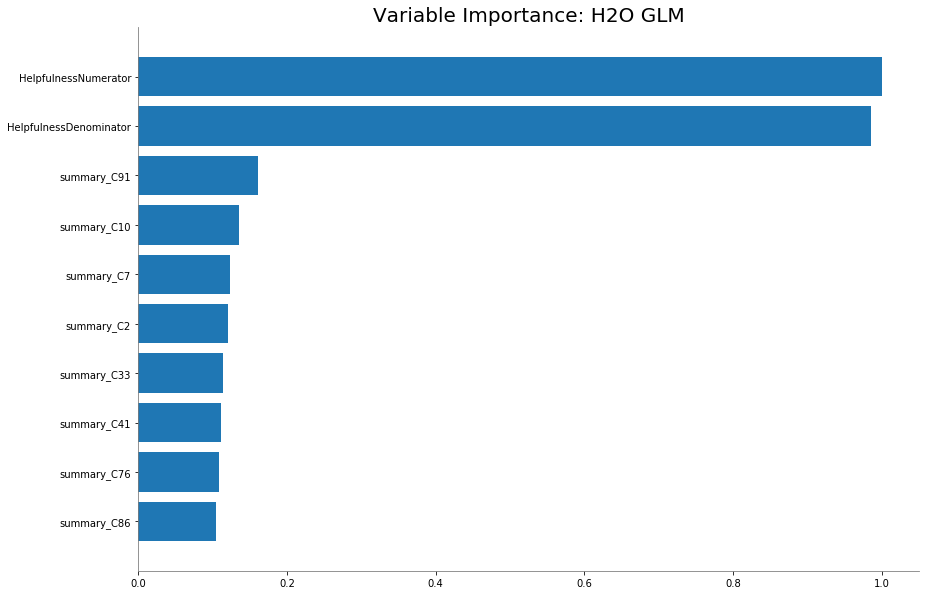

In [135]:
local_glm_plus.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


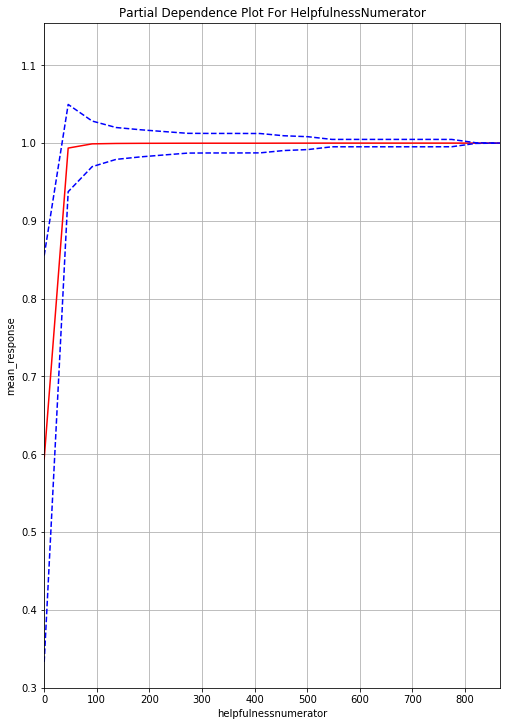

In [136]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train, cols = ["HelpfulnessNumerator"])

### 11. Train Decision Tree Model to Predict Good Review--Ziwei:

- a single decision tree will be trained on the original inputs and predictions of the h2o GBM model and the tree will be visualized using special functionality in h2o and GraphViz. 

In [72]:
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

#### 11.1 Train decision tree surrogate model-Without Summary:

In [73]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

In [74]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [75]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='../../../../../../../../../Learning/DataScience')

print(surrogate)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.22720625436888103
RMSE: 0.47666157215458543
LogLoss: 0.646623252503391
Mean Per-Class Error: 0.4129607911392914
AUC: 0.6169717620607368
pr_auc: 0.701813978582726
Gini: 0.23394352412147357
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6306452274172152: 


,0,1,Error,Rate
0,1918.0,13976.0,0.8793,(13976.0/15894.0)
1,686.0,27822.0,0.0241,(686.0/28508.0)
Total,2604.0,41798.0,0.3302,(14662.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6306452,0.7914545,5.0
max f2,0.6133597,0.9004613,6.0
max f0point5,0.6368217,0.7148976,4.0
max accuracy,0.6306452,0.6697896,5.0
max precision,0.6530382,0.7527675,0.0
max recall,0.5925922,1.0,7.0
max specificity,0.6530382,0.9873537,0.0
max absolute_mcc,0.6306452,0.1971190,5.0
max min_per_class_accuracy,0.6448321,0.5260476,2.0
max mean_per_class_accuracy,0.6443128,0.5870392,3.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.20 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0183100,0.6530382,1.1724563,1.1724563,0.7527675,0.6530382,0.7527675,0.6530382,0.0214677,0.0214677,17.2456285,17.2456285
,2,0.3222603,0.6512438,1.1441412,1.1457500,0.7345880,0.6512438,0.7356209,0.6513457,0.3477620,0.3692297,14.4141207,14.5749996
,3,0.5781722,0.6448321,1.0435148,1.1004984,0.6699815,0.6448321,0.7065675,0.6484627,0.2670478,0.6362775,4.3514782,10.0498409
,4,0.6970182,0.6443128,1.0354003,1.0893988,0.6647717,0.6443128,0.6994410,0.6477551,0.1230532,0.7593307,3.5400268,8.9398765
,5,0.8581821,0.6368217,0.9189326,1.0573858,0.5899944,0.6368217,0.6788873,0.6457018,0.1480988,0.9074295,-8.1067356,5.7385760
,6,0.9413540,0.6306452,0.8236804,1.0367371,0.5288383,0.6306452,0.6656299,0.6443715,0.0685071,0.9759366,-17.6319626,3.6737069
,7,1.0,0.5925922,0.4103164,1.0,0.2634409,0.6033189,0.6420432,0.6419640,0.0240634,1.0,-58.9683560,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-02 13:46:40,0.017 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-02 13:46:40,0.156 sec,1.0,0.4766616,0.6466233,0.6169718,0.7018140,1.1724563,0.3302104


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
HelpfulnessNumerator,266.5761719,1.0,0.4424212
HelpfulnessDenominator,258.5619202,0.9699364,0.4291204
ProductId,58.4961052,0.2194349,0.0970826
Time,18.9051323,0.0709183,0.0313758
UserId,0.0,0.0,0.0



Generated MOJO path:
 C:\Learning\DataScience\dt_surrogate_mojo.zip


#### 11.2 Generate GraphViz representation of MOJO:

- GraphViz is an open source graph visualization tool. It is freely available from this url: http://www.graphviz.org/.  
- To plot the trained decision tree surrogate model, a special h2o class, __PrintMojo__, is executed against the MOJO to create a GraphViz dot file representation of the tree.  
        

- Create GraphViz dot file:

In [76]:
from h2o.backend import H2OLocalServer
import subprocess

In [77]:
details = False # print more info on tree, details = True
title = 'Amazon Reviews Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 c:\python37\lib\site-packages\h2o\backend\bin\h2o.jar

Calling external process ...
java -cp c:\python37\lib\site-packages\h2o\backend\bin\h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i C:\Learning\DataScience\dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Amazon Reviews Decision Tree Surrogate


#### 11.3 Generate PNG from GraphViz representation

In [78]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


#### 11.4 Display decision tree surrogate

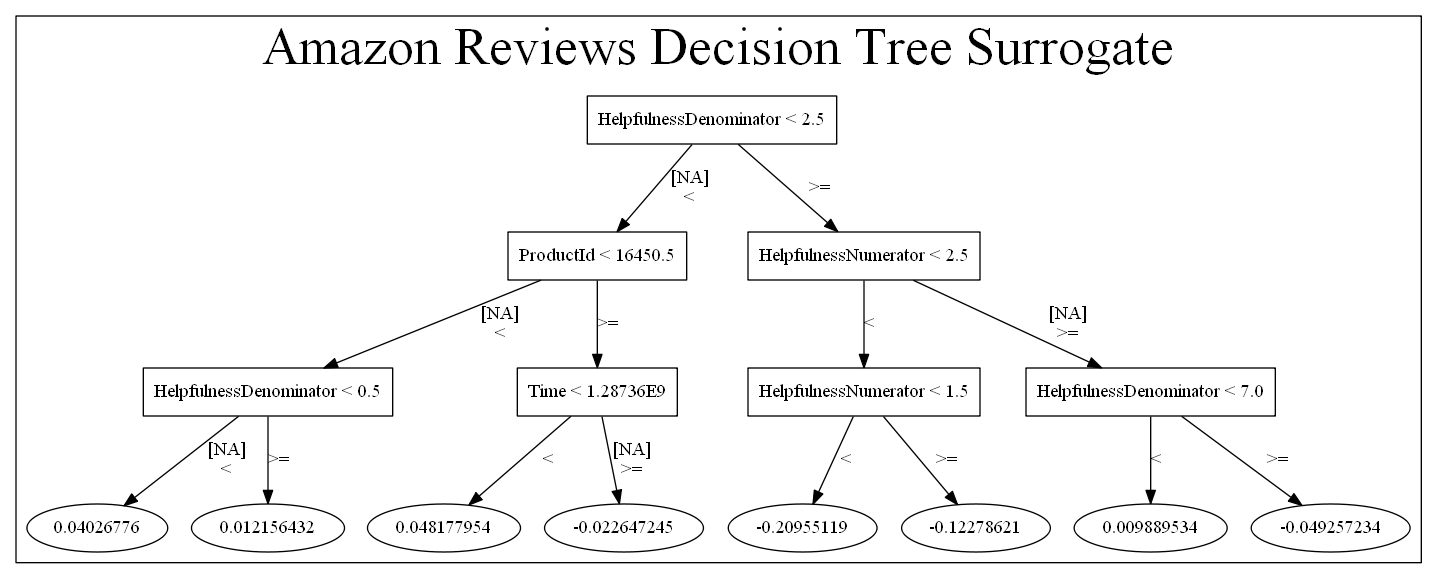

In [79]:
display(Image((png_file_name)))

#### From this surrogate model we can see...  the decision path without summary:
- Some of the most important variables
- Important interactions
- The decision path for the most negative reviews
- The decision path for the most positive reviews

#### 11.5 AUC & Confusion Matrix-Without Summary:

In [80]:
dt_performance = surrogate.model_performance(ext_test)
dt_performance.auc()

0.5510744996455851

In [81]:
surrogate.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6306452274172152: 


,0,1,Error,Rate
0,1918.0,13976.0,0.8793,(13976.0/15894.0)
1,686.0,27822.0,0.0241,(686.0/28508.0)
Total,2604.0,41798.0,0.3302,(14662.0/44402.0)


In [82]:
surrogate.r2(train=True, valid=True)

{'train': 0.01138911406297094, 'valid': None}

#### 11.6 Train With summary:

In [83]:
predictors = predictors + summary_vecs.names
response = 'PositiveReview'

In [84]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo_WithSummary'

# train single tree surrogate model
surrogate_plus = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate_plus.train(x=predictors, y=response, training_frame=ext_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [85]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate_plus.download_mojo(path='../../../../../../../../../Learning/DataScience')

print(surrogate_plus)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo_WithSummary


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2247968275996043
RMSE: 0.474127438142536
LogLoss: 0.6413462404814723
Mean Per-Class Error: 0.3500468583353069
AUC: 0.6938619175932089
pr_auc: 0.4829607600757417
Gini: 0.38772383518641784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6264891161727294: 


,0,1,Error,Rate
0,4766.0,11128.0,0.7001,(11128.0/15894.0)
1,2729.0,25779.0,0.0957,(2729.0/28508.0)
Total,7495.0,36907.0,0.3121,(13857.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6264891,0.7881679,6.0
max f2,0.6137990,0.8996806,7.0
max f0point5,0.6389462,0.7496684,4.0
max accuracy,0.6281197,0.6886852,5.0
max precision,0.6603034,0.8268297,0.0
max recall,0.6137990,1.0,7.0
max specificity,0.6603034,0.8654209,0.0
max absolute_mcc,0.6389462,0.3023854,4.0
max min_per_class_accuracy,0.6466159,0.6243866,2.0
max mean_per_class_accuracy,0.6461853,0.6499531,3.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.19 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2781857,0.6603034,1.2878101,1.2878101,0.8268297,0.6603034,0.8268297,0.6603034,0.3582503,0.3582503,28.7810113,28.7810113
,2,0.5179046,0.6473066,1.0822506,1.1926642,0.6948516,0.6473066,0.7657419,0.6542877,0.2594359,0.6176863,8.2250559,19.2664180
,3,0.6305797,0.6461853,1.0672007,1.1702457,0.6851889,0.6463461,0.7513483,0.6528686,0.1202469,0.7379332,6.7200679,17.0245740
,4,0.7994910,0.6281197,0.8421033,1.1009179,0.5406667,0.6318281,0.7068368,0.6484233,0.1422408,0.8801740,-15.7896684,10.0917923
,5,0.8312013,0.6264891,0.7599585,1.0879103,0.4879261,0.6264891,0.6984854,0.6475865,0.0240985,0.9042725,-24.0041521,8.7910339
,6,1.0,0.6137990,0.5671105,1.0,0.3641094,0.6137990,0.6420432,0.6418832,0.0957275,1.0,-43.2889510,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-02 13:46:57,0.002 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-02 13:46:58,0.243 sec,1.0,0.4741274,0.6413462,0.6938619,0.4829608,1.2878101,0.3120805


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
summary_C55,480.3755493,1.0,0.4106890
summary_C91,366.3369446,0.7626053,0.3131936
summary_C10,154.9094696,0.3224758,0.1324372
summary_C76,116.7457504,0.2430302,0.0998098
summary_C54,51.3144684,0.1068216,0.0438704
---,---,---,---
summary_C96,0.0,0.0,0.0
summary_C97,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Generated MOJO path:
 C:\Learning\DataScience\dt_surrogate_mojo_WithSummary.zip


In [86]:
details = False # print more info on tree, details = True
title = 'Amazon Reviews Decision Tree Surrogate-With Summary'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 c:\python37\lib\site-packages\h2o\backend\bin\h2o.jar

Calling external process ...
java -cp c:\python37\lib\site-packages\h2o\backend\bin\h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i C:\Learning\DataScience\dt_surrogate_mojo_WithSummary.zip -o dt_surrogate_mojo_WithSummary.gv --title Amazon Reviews Decision Tree Surrogate-With Summary


In [87]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo_WithSummary.gv -o dt_surrogate_mojo_WithSummary.png


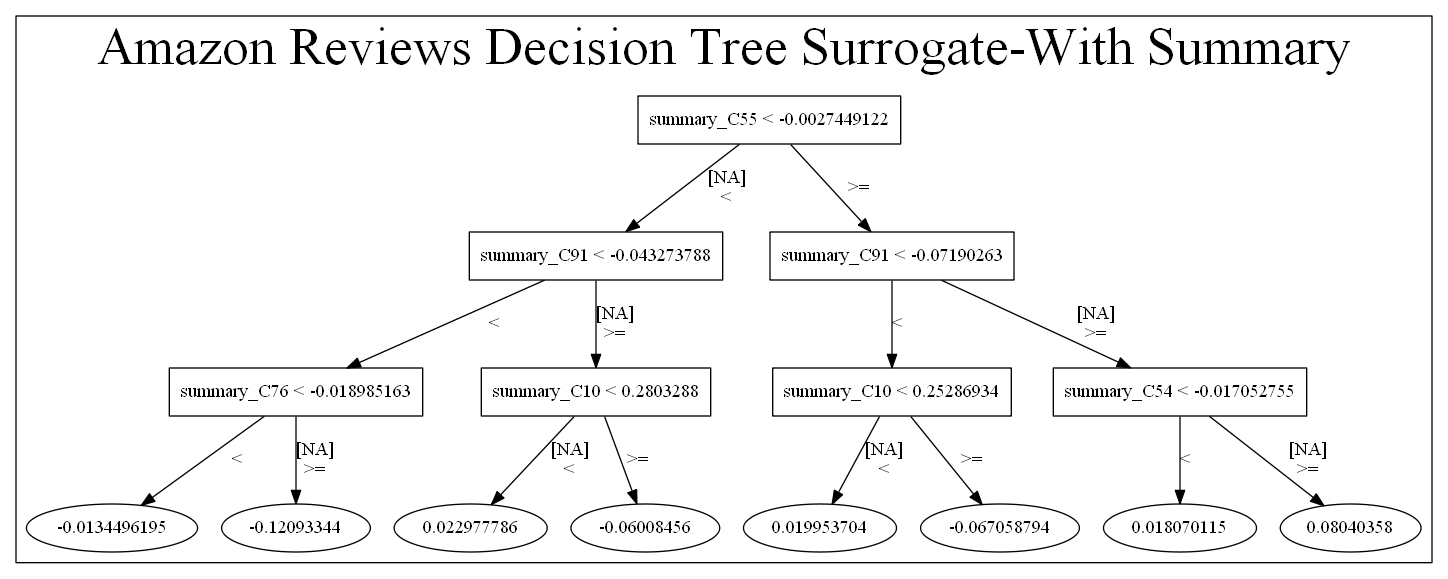

In [88]:
display(Image((png_file_name)))

#### From this surrogate model we can see...  the decision path adding summary:
- Some of the most important variables
- Important interactions
- The decision path for the most negative reviews
- The decision path for the most positive reviews

In [89]:
dt_performance = surrogate_plus.model_performance(ext_test)
dt_performance.auc()

0.6924513911125343

In [90]:
surrogate_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6264891161727294: 


,0,1,Error,Rate
0,4766.0,11128.0,0.7001,(11128.0/15894.0)
1,2729.0,25779.0,0.0957,(2729.0/28508.0)
Total,7495.0,36907.0,0.3121,(13857.0/44402.0)


In [91]:
surrogate_plus.r2(train=True, valid=True)

{'train': 0.0218729167188072, 'valid': None}

- Most of the variables pictured in this tree also appear as highly important in the GBM variable importance plot.   
- e.g.:  For instance, to fall into the lowest probability of default leaf node in the surrogate decision tree a customer must make their first and second payments in a timely fashion and then pay more than 1515.5 Dollars for their fifth payment.   
- The global explanatory methods applied thus far tell a consisent and reasonable story about the GBM's behavior. If this was not so, steps should be taken to either reconcile or remove inconsistencies and unreasonable prediction behavior.

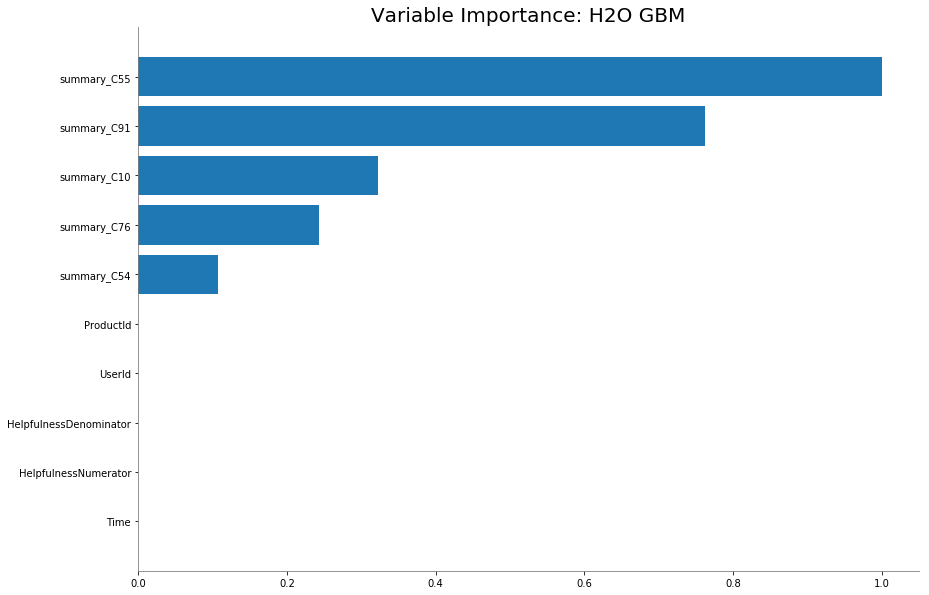

In [94]:
surrogate_plus.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


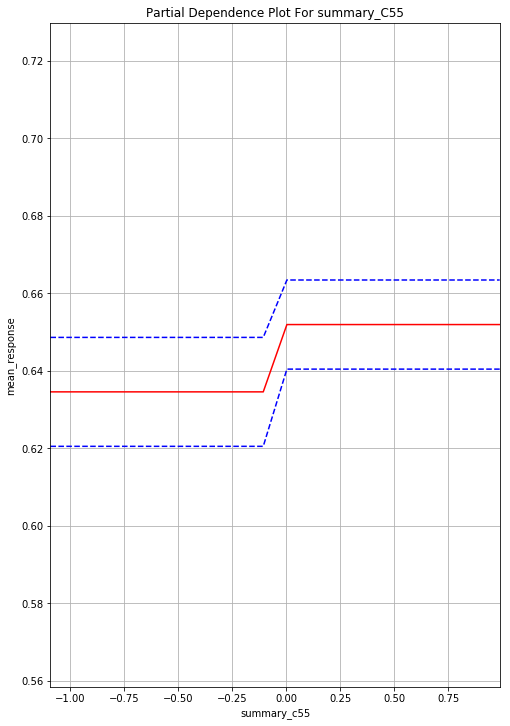

In [96]:
pdp_tree = surrogate_plus.partial_plot(data = ext_train, cols = ["summary_C55"])

### 13 Pick the model with best performance--Logistic Regression:

#### Helper function for finding quantile indices

In [92]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

In [93]:
quantile_dict = get_quantile_dict(response, 'Id', ext_train)

ParserError: Error tokenizing data. C error: Expected 212 fields in line 29, saw 216
